# Assignment 2
## Task 6

In [1]:
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from os import walk
%matplotlib inline
figsize = (15,22)

def _plot(img, title=''):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(img)
    
def read_img(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, dsize=(0,0), fx=0.25, fy=0.25)

### Implementation

Algorithm is build based on [PatchMatch](https://gfx.cs.princeton.edu/pubs/Barnes_2009_PAR/patchmatch.pdf) paper.
As a skeleton for some function, [MingtaoGuo](https://github.com/MingtaoGuo/PatchMatch) repository was referenced

In [2]:
def ConstructImage(f, ref, shape):
    imgR, imgC, _ = shape
    img = np.zeros(shape, dtype=np.int)
    for i in range(imgR):
        for j in range(imgC):
            refPos = f[i, j]
            img[i, j, :] = ref[refPos[0], refPos[1], :]
    return img

In [3]:
def Distance(imgPos, refPos, imgPad, ref, patchSize):
    imgI, imgJ = imgPos
    imgPatch = imgPad[imgI:imgI+patchSize, imgJ:imgJ+patchSize, :]
    
    refI, refJ = refPos
    p = patchSize // 2
    refPatch = ref[refI-p:refI+p+1, refJ-p:refJ+p+1, :]
    
    diff = refPatch - imgPatch
    numberCount = np.sum(1 - np.isnan(diff))
    return np.sum(np.square(np.nan_to_num(diff))) / numberCount

In [4]:
def RandomSearch(f, imgPos, imgPad, ref, patchSize, alpha=0.5):
    i,j = imgPos
    refR, refC, _ = ref.shape
    p = patchSize // 2
    it = 3
    
    refPosX, refPosY = f[i, j]
    while True:
        it += 1
        spanR = round(refR * alpha ** it + 0.5)
        spanC = round(refC * alpha ** it + 0.5)
        
        if spanR <= 1 or spanC <= 1:
            break
        
        search_min_r = max(refPosX - spanR, p)
        search_max_r = min(refPosX + spanR, refR-p)
        randomRefPosX = np.random.randint(search_min_r, search_max_r)
        
        search_min_c = max(refPosY - spanC, p)
        search_max_c = min(refPosY + spanC, refC - p)
        randomRefPosY = np.random.randint(search_min_c, search_max_c)
        
        newRefPos = np.array([randomRefPosX, randomRefPosY])
        newDist = Distance(imgPos, newRefPos, imgPad, ref, patchSize)
        currDist = Distance((i,j), f[i,j], imgPad, ref, patchSize)
        if newDist < currDist:
            f[i, j] = newRefPos
            
    return f

In [5]:
def Propagation(f, imgPos, imgPad, ref, patchSize, isForward):
    imgR = np.size(imgPad, 0) - patchSize
    imgC = np.size(imgPad, 1) - patchSize
    i,j = imgPos
    imgPosColl = []
    if isForward:
        imgPosColl = [(max(i-1, 0), j), (i, max(j-1, 0)), (i, j)]
    else: 
        imgPosColl = [(min(i+1, imgR-1), j), (i, min(j + 1, imgC-1)), (i, j)]

    refPosColl = [f[p[0], p[1]] for p in imgPosColl]
    distColl = [Distance(imgPosColl[i], refPosColl[i], imgPad, ref, patchSize) for i in range(len(imgPosColl))]
        
    idx = np.argmin(distColl)
    f[i, j] = refPosColl[idx]
    return f

In [6]:
def Initialization(img, ref, patchSize):
    imgR, imgC, _ = img.shape
    refR, refC, _ = ref.shape
    
    imgPad = np.ones([imgR+patchSize, imgC+patchSize, 3]) * np.nan
    p = patchSize // 2
    imgPad[p:imgR+p, p:imgC+p, :] = img
    
    getNextRefPos = lambda: (np.random.randint(p, refR-p),
                             np.random.randint(p, refC-p))

    f = np.zeros([imgR, imgC], dtype=object)
    for i in range(imgR):
        for j in range(imgC):
            f[i, j] = getNextRefPos()
    
    return f, imgPad

In [7]:
def NearestNeighborField(img, ref, patchSize, iterations):
    print('NearestNeighborField Started')
    imgR, imgC, _ = img.shape
    refR, refC, _ = ref.shape
    result = []
    f, imgPad = Initialization(img, ref, patchSize)
    for it in range(iterations):
        isForward = (it % 2 == 0)
        rowIter = range(imgR) if isForward else range(imgR - 1, -1, -1)
        colIter = range(imgC) if isForward else range(imgC - 1, -1, -1)
        for i in rowIter:
            for j in colIter:
                imgPos = (i,j)
                f = Propagation(f, imgPos, imgPad, ref, patchSize, isForward)
                f = RandomSearch(f, imgPos, imgPad, ref, patchSize)
                
        result.append(f)
        print('Iteration {} completed'.format(it+1))
        
    return result

### Original Image

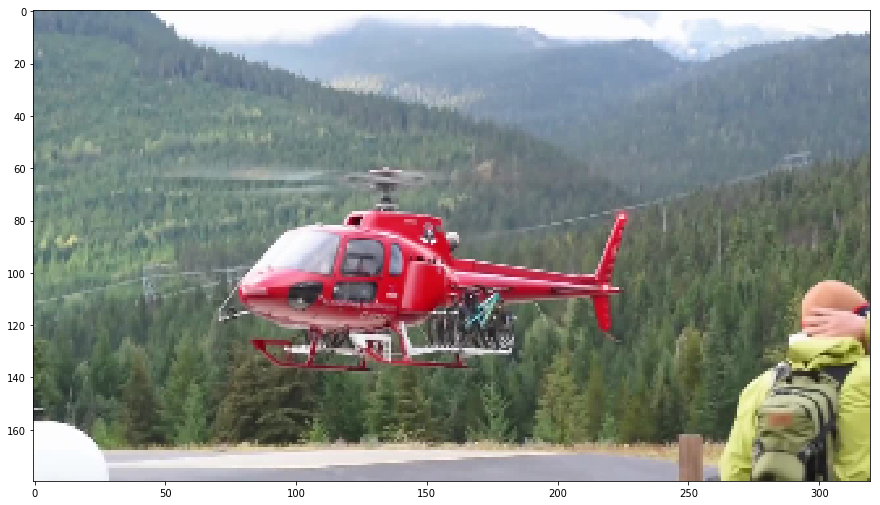

In [8]:
img = read_img('./res/frames/v001.jpg')
_plot(img)

### Reference Image

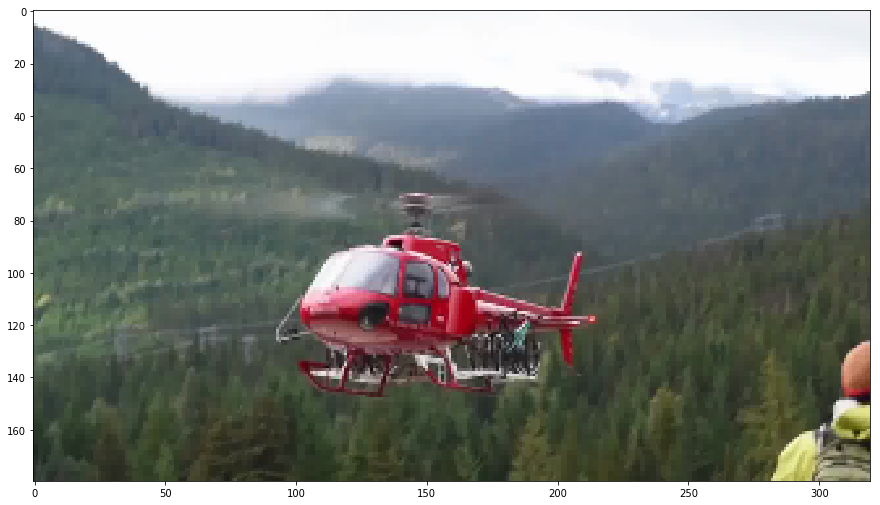

In [9]:
ref = read_img('./res/frames/v025.jpg')
_plot(ref)

### Reconstruction

In [10]:
patchSize = 5
iterations = 5

result = NearestNeighborField(img, ref, patchSize, iterations)

NearestNeighborField Started
Iteration 1 completed
Iteration 2 completed
Iteration 3 completed
Iteration 4 completed
Iteration 5 completed


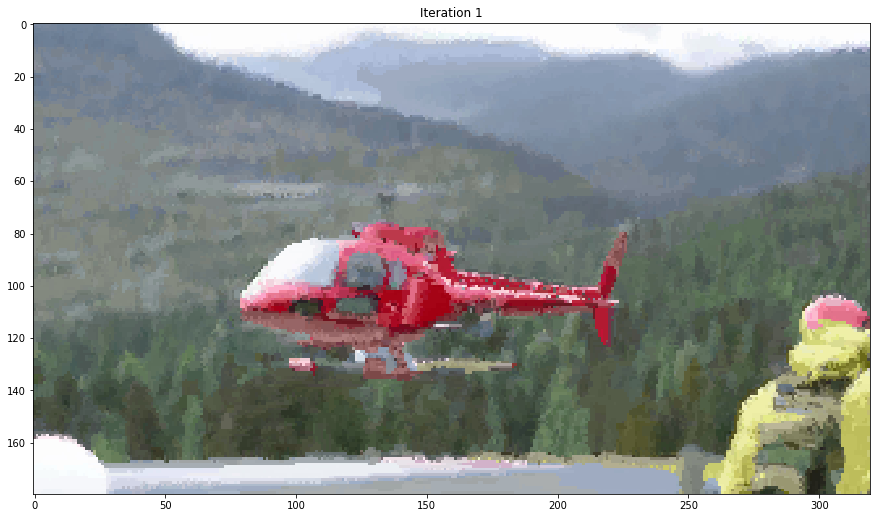

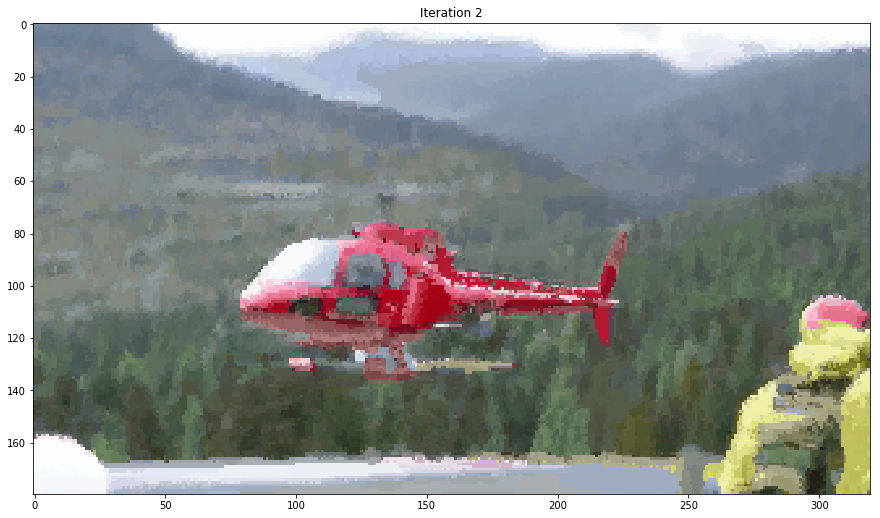

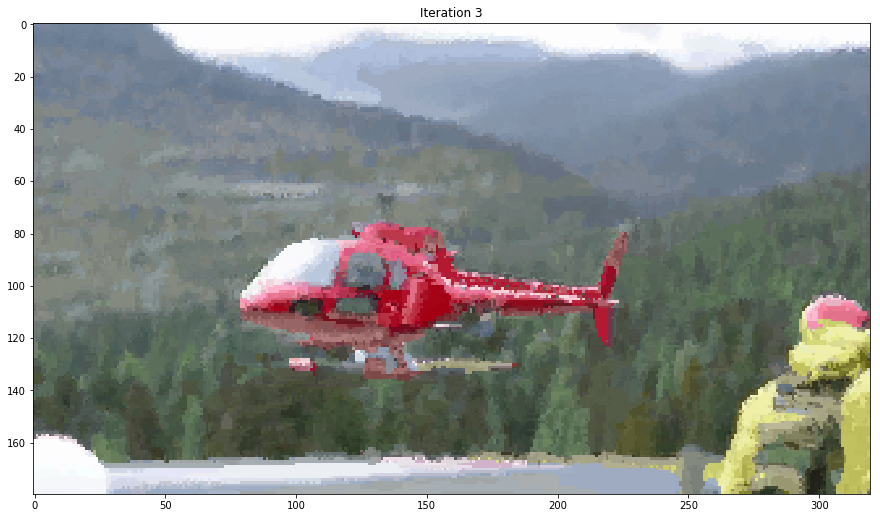

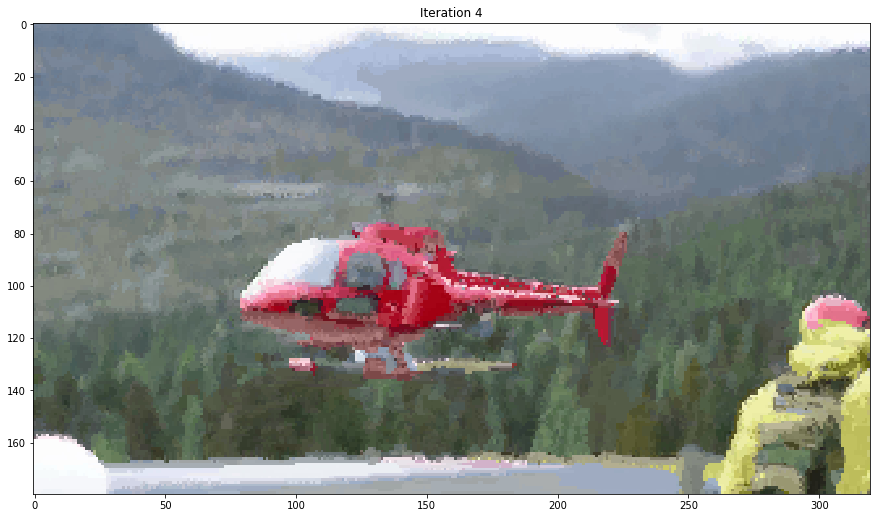

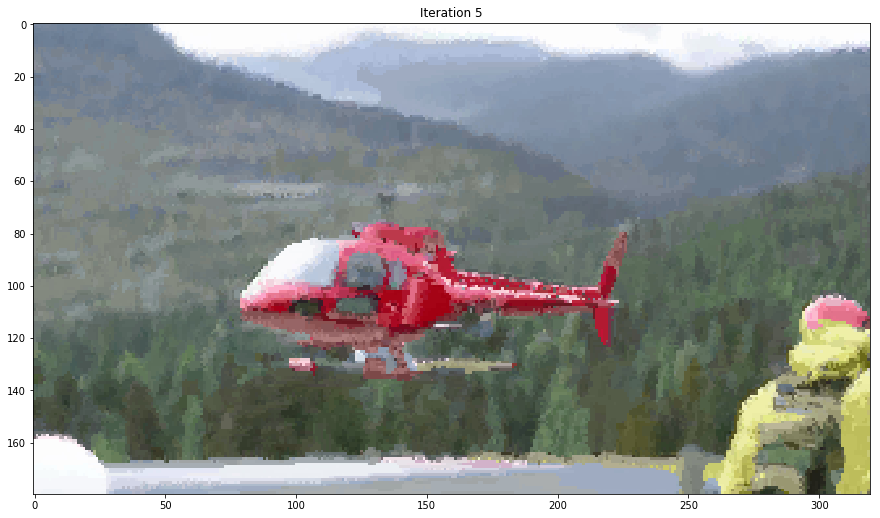

In [11]:
for i in range(len(result)):
    reconstructedImg = ConstructImage(result[i], ref, img.shape)
    _plot(reconstructedImg, 'Iteration {}'.format(i+1))